## Fundamental Matrix Estimation

- Students: Le Thi Hoa - Tran Hai Linh - Sophin CHHENG

**Content:**
- Take two pictures of the same configuration of Rubik’s cube, estimate Fundamental Matrix.
1. Display the epipolar lines. Comment on how can you interpret the accuracy of estimated
matrix from the visual results.
2. Normalize the data and recompute the fundamental matrix. Does it improve the
accuracy? Explain your reasoning.

### Introduction: 
- In this part, we aim to estimate the Fundamental Matrix from two images of the same configuration of a Rubik’s cube. The Fundamental Matrix is a crucial element in computer vision, particularly in stereo vision applications. It represents the epipolar geometry between two images, allowing us to establish correspondences between points in the two images.


### Import required libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

###  Image Loading and Preprocessing:
- **Description:** This function reads two input images from specified paths.
- **Purpose:** It provides the initial data for further processing, allowing the algorithm to work with the actual images.


In [2]:
def read_images(image_path1, image_path2):
    img1 = cv2.imread(image_path1, cv2.IMREAD_COLOR)
    img2 = cv2.imread(image_path2, cv2.IMREAD_COLOR)
    return img1, img2

### Feature Detection and Description:
- **Description:** Utilizes the ORB (Oriented FAST and Rotated BRIEF) algorithm to find keypoints and compute descriptors for each image.
- **Purpose:** Identifying distinctive points and extracting features that can be matched between the images.


In [3]:
def find_keypoints_and_descriptors(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(gray, None)
    return keypoints, descriptors


### Feature Matching:
- **Description:** Matches the descriptors of keypoints in both images using the Brute-Force Matcher.
- **Purpose:** Establishing correspondences between keypoints, forming the basis for subsequent geometric analysis.


In [4]:
def match_features(des1, des2):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches


### Visualization of Feature Matches:
- **Description:** Draws lines connecting matched features between the two images.
- **Purpose:** Offers a visual representation of the matched keypoints, aiding in the assessment of feature matching accuracy.

In [5]:
def draw_matches(img1, img2, kp1, kp2, matches):
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=10)
    img_matches = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
    plt.imshow(img_matches)
    plt.title('Feature Matching (with ORB)')
    plt.axis('off')
    plt.show()

###  Visualization of Epipolar Lines:
- **Description:** Estimates the fundamental matrix using a set of matched keypoints.
- **Purpose:** Provides a mathematical model representing the geometric relationship between the two camera views.

In [6]:
def draw_epipolar_lines(img1, img2, pts1, pts2, F_matrix, num_lines=20, line_thickness=2):
    # Compute epilines for the second image and draw on the first image
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F_matrix).reshape(-1, 3)
    img1_lines = img1.copy()
    for i in range(min(num_lines, len(lines1))):
        line = lines1[i]
        pt1 = pts1[i]
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0, x1, y1 = map(int, [0, -line[2] / line[1], img1.shape[1], -(line[2] + line[0] * img1.shape[1]) / line[1]])
        img1_lines = cv2.line(img1_lines, (x0, y0), (x1, y1), color, line_thickness)
        img1_lines = cv2.circle(img1_lines, tuple(map(int, pt1)), 4, color, -1)

    # Compute epilines for the first image and draw on the second image
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F_matrix).reshape(-1, 3)
    img2_lines = img2.copy()
    for i in range(min(num_lines, len(lines2))):
        line = lines2[i]
        pt2 = pts2[i]
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0, x1, y1 = map(int, [0, -line[2] / line[1], img2.shape[1], -(line[2] + line[0] * img2.shape[1]) / line[1]])
        img2_lines = cv2.line(img2_lines, (x0, y0), (x1, y1), color, line_thickness)
        img2_lines = cv2.circle(img2_lines, tuple(map(int, pt2)), 4, color, -1)

    return img1_lines, img2_lines


### Complete Workflow and Visualization:
- **Description:** Computes and visualizes epipolar lines corresponding to matched keypoints in both images.
- **Purpose:** Facilitates the qualitative evaluation of the accuracy of the estimated fundamental matrix.

In [7]:
def visualize_epipolar_lines(image_path1, image_path2, type_estimate_matrix):
    # Read images
    img1, img2 = read_images(image_path1, image_path2)

    # Find keypoints and descriptors
    keypoints1, descriptors1 = find_keypoints_and_descriptors(img1)
    keypoints2, descriptors2 = find_keypoints_and_descriptors(img2)

    # Match features
    matches = match_features(descriptors1, descriptors2)

    # Draw matches
    draw_matches(img1, img2, keypoints1, keypoints2, matches)

    # Extract matched points
    pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

    # Estimate Fundamental Matrix
    F_matrix = type_estimate_matrix(pts1, pts2)

    # Draw epipolar lines
    img1_lines, img2_lines = draw_epipolar_lines(img1, img2, pts1, pts2, F_matrix)

    # Display images with epipolar lines
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img1_lines)
    plt.title('Image 1 with Epipolar Lines')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2_lines)
    plt.title('Image 2 with Epipolar Lines')
    plt.axis('off')

    plt.show()


### Display the epipolar lines. Comment on how can you interpret the accuracy of estimated matrix from the visual results

### Fundamental Matrix Estimation Without Normalization:

In [8]:
def estimate_fundamental_matrix_no_normalization(pts1, pts2):
    # Ensure we have at least 8 corresponding points
    if len(pts1) < 8 or len(pts2) < 8:
        raise ValueError("Insufficient corresponding points for Fundamental Matrix estimation.")

    # Build the matrix A for the homogeneous linear system
    A = np.zeros((len(pts1), 9))
    for i in range(len(pts1)):
        u1, v1 = pts1[i]
        u2, v2 = pts2[i]
        A[i] = [u1 * u2, v1 * u2, u2, u1 * v2, v1 * v2, v2, u1, v1, 1]

    # Solve for the singular vector of A corresponding to the smallest singular value
    _, _, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)

    # Enforce rank 2 constraint by setting the smallest singular value to 0
    U, S, V = np.linalg.svd(F)
    S[2] = 0
    F = U @ np.diag(S) @ V

    return F

### Display Epipolar Lines

#### Example 1: 

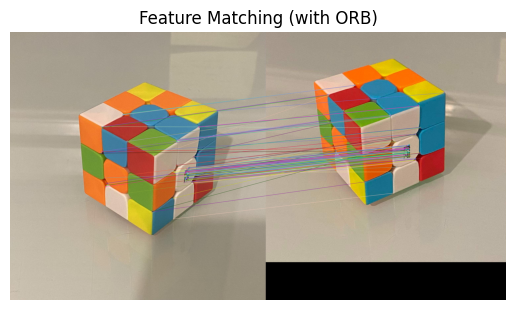

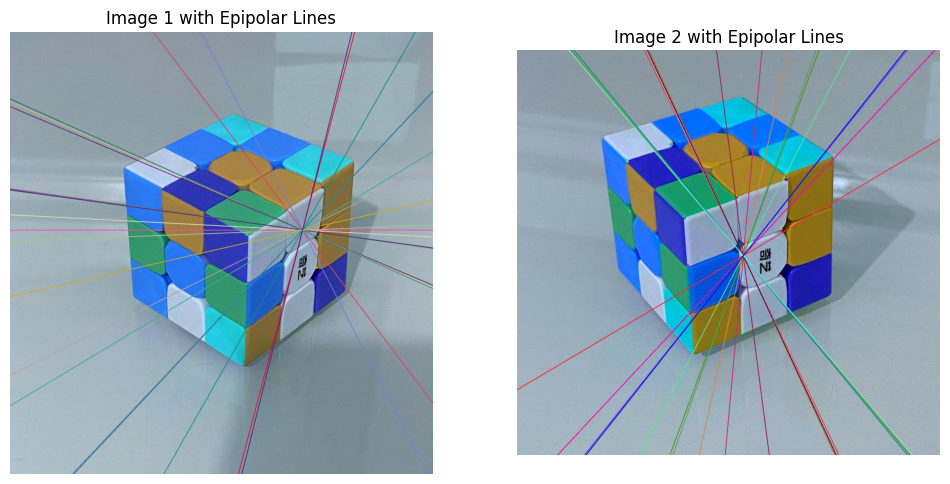

In [9]:
image_path1 = 'input/h1.jpeg'
image_path2 = 'input/h3.png'
visualize_epipolar_lines(image_path1, image_path2, type_estimate_matrix=estimate_fundamental_matrix_no_normalization)

#### Example 2: 

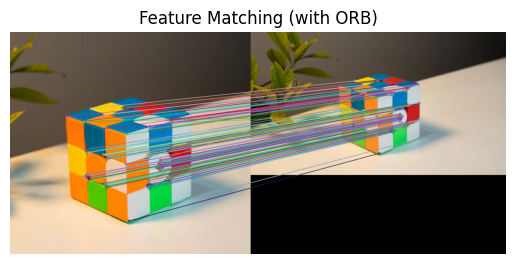

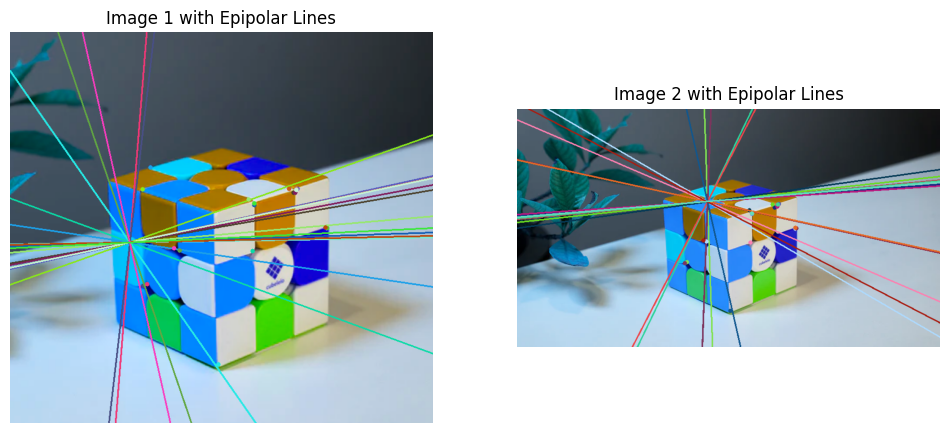

In [10]:
image_path1 = 'input/p1.png'
image_path2 = 'input/p2.png'
visualize_epipolar_lines(image_path1, image_path2, type_estimate_matrix=estimate_fundamental_matrix_no_normalization)


#### Conclusion: 
- The epipolar lines appear to converge at different points, indicating that the stereo images are uncalibrated. The lines do not intersect at the same point on the cube, which can lead to inaccuracies when trying to match points between the two views.


### Normalize the data and recompute the fundamental matrix. Does it improve the accuracy? Explain your reasoning.


### Fundamental Matrix Estimation With Normalization:

In [11]:
def normalize_points(pts):
    # Compute the centroid of the points
    centroid = np.mean(pts, axis=0)

    # Compute the average distance to the centroid
    avg_distance = np.mean(np.sqrt(np.sum((pts - centroid) ** 2, axis=1)))

    # Scale and translate the points to have mean distance sqrt(2) from the centroid
    scale = np.sqrt(2) / avg_distance
    translation = -scale * centroid

    # Build the normalization matrix
    T = np.array([[scale, 0, translation[0]],
                  [0, scale, translation[1]],
                  [0, 0, 1]])

    # Apply normalization to the points
    pts_normalized = np.column_stack((pts, np.ones(len(pts))))
    pts_normalized = (T @ pts_normalized.T).T[:, :2]

    return pts_normalized, T


In [12]:
def estimate_fundamental_matrix(pts1, pts2):
    # Ensure we have at least 8 corresponding points
    if len(pts1) < 8 or len(pts2) < 8:
        raise ValueError("Insufficient corresponding points for Fundamental Matrix estimation.")

    # Normalize the coordinates for numerical stability
    pts1_normalized, T1 = normalize_points(pts1)
    pts2_normalized, T2 = normalize_points(pts2)

    # Build the matrix A for the homogeneous linear system
    A = np.zeros((len(pts1_normalized), 9))
    for i in range(len(pts1_normalized)):
        u1, v1 = pts1_normalized[i]
        u2, v2 = pts2_normalized[i]
        A[i] = [u1 * u2, v1 * u2, u2, u1 * v2, v1 * v2, v2, u1, v1, 1]

    # Solve for the singular vector of A corresponding to the smallest singular value
    _, _, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)

    # Enforce rank 2 constraint by setting the smallest singular value to 0
    U, S, V = np.linalg.svd(F)
    S[2] = 0
    F = U @ np.diag(S) @ V

    # Denormalize the fundamental matrix
    F = np.dot(T2.T, np.dot(F, T1))

    return F


### Display the result 

#### Example 1:

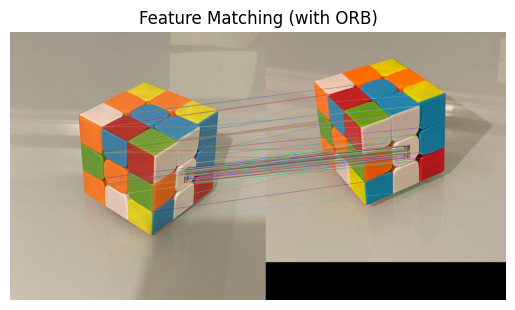

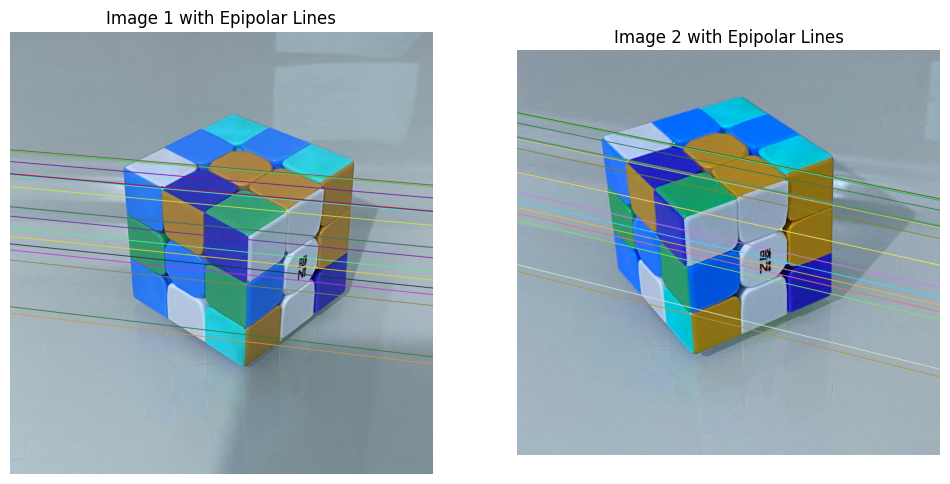

In [13]:
image_path1 = 'input/h1.jpeg'
image_path2 = 'input/h3.png'
visualize_epipolar_lines(image_path1, image_path2, type_estimate_matrix=estimate_fundamental_matrix)

#### Example 2: 

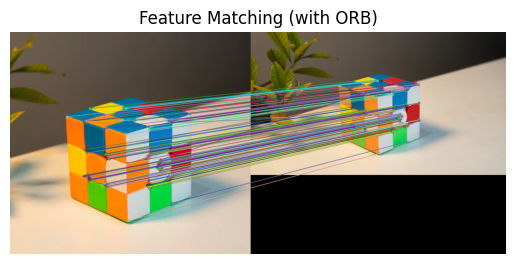

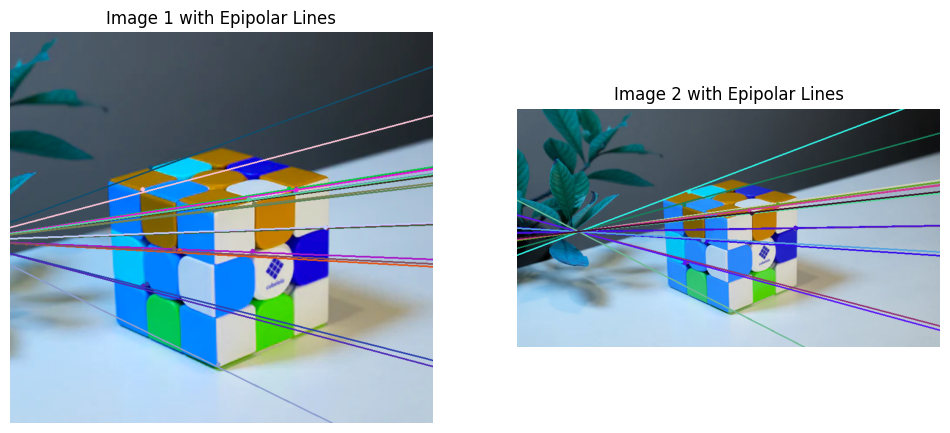

In [14]:
image_path1 = 'input/p1.png'
image_path2 = 'input/p2.png'
visualize_epipolar_lines(image_path1, image_path2, type_estimate_matrix=estimate_fundamental_matrix)

#### Conclusion: 
- The epipolar lines are more parallel and organized. This suggests that the data has been normalized through a process such as rectification, which aligns the images and makes the corresponding epipolar lines horizontal and parallel. This is a crucial step in stereo vision processing as it simplifies the problem of finding corresponding points to a one-dimensional search along the epipolar lines.
- Epipolar Line Convergence: In a well-normalized image, the epipolar lines should ideally converge at the same epipole in each image.

- **Normalizing data improves accuracy for several reasons:**
    - Uniform Scale and Units: Normalization ensures a consistent scale and units for data points, making them independent of factors like image size, aspect ratio, or resolution. This reduces distortion and ensures that corresponding points in both images belong to the same spatial frame.
    - Reduction of Scale Discrepancies: Normalizing images makes epipolar lines less skewed and often straight, facilitating the estimation of the fundamental matrix. This results in easier and more accurate estimation.
    - Consistency in Measurement Units: Data normalization unifies the measurement units of image points, making operations and computations consistent and easy to interpret.
    - Increased Stability of Algorithms: Algorithms related to epipolar lines, such as fundamental matrix estimation, are often designed to work well with normalized data. This enhances the stability and accuracy of the algorithms.
    - Reduced Impact of Noise and Variability: Normalization can reduce the impact of noise and variability in the data, making prediction and estimation methods more reliable.

